In [189]:
import io
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
from scipy.signal import convolve as conv

%matplotlib notebook

plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

# Reinforcement learning

Today we want to investigate some RL algorithms and how they can be used to train an agent that moves around in a grid environment.

## The cliff
First, we setup the viusal representation of the environment

TODO - explain the environment

<IPython.core.display.Javascript object>


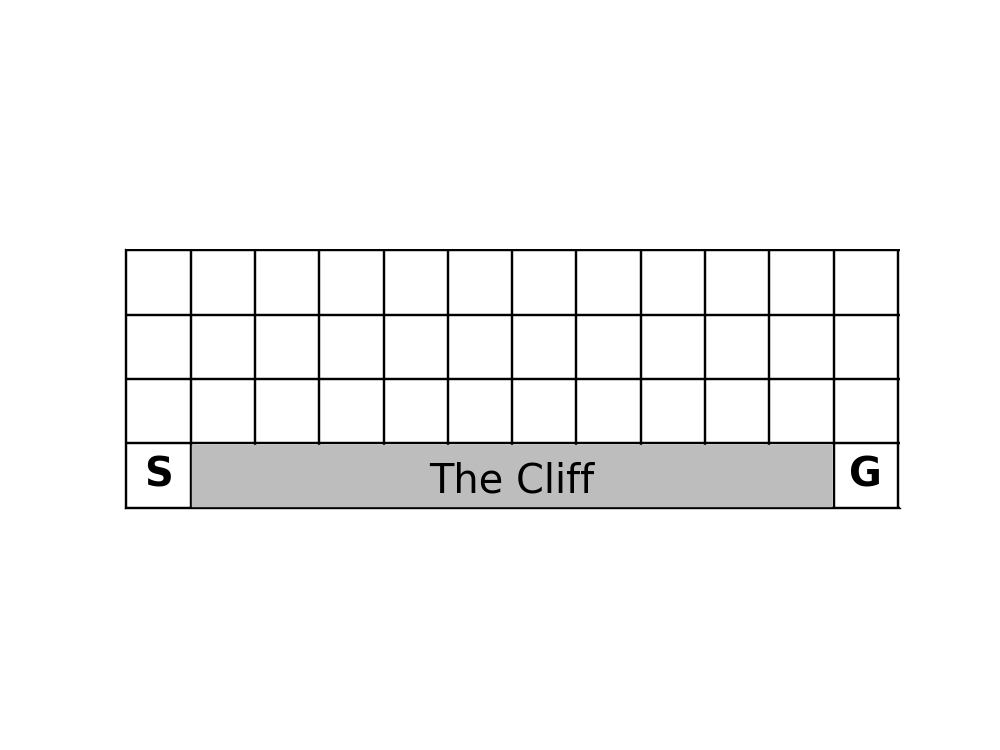

<AxesSubplot:>

In [360]:
def show_grid_world(ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,6))



    ax.grid(linewidth = 1.4, c='k')
    ax.set(
        xticks = [0.5+ii for ii in range(-1,12)],
        yticks = [0.5 + ii for ii in range(-1,4)],
        xlim=[-0.52,11.53],
        ylim = [-0.51,3.52])


    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    ax.set_aspect('equal', adjustable='box')
    rect=mpatches.Rectangle((0.52,-0.49),9.96,0.96, 
                            fill=True,
                            color="#bdbdbd",zorder=50)
    ax.add_patch(rect)

    ax.annotate('S',(0,0), fontweight='bold',fontsize=23,ha='center',va='center',zorder=80)
    ax.annotate('G',(11,0), fontweight='bold',fontsize=23,ha='center',va='center',zorder=80)
    ax.annotate('The Cliff',(5.5,-0.1), fontsize=23,ha='center',va='center',zorder=80)
    return ax
show_grid_world()

## Moving in the environment

The agent is able to move in the environment



<IPython.core.display.Javascript object>


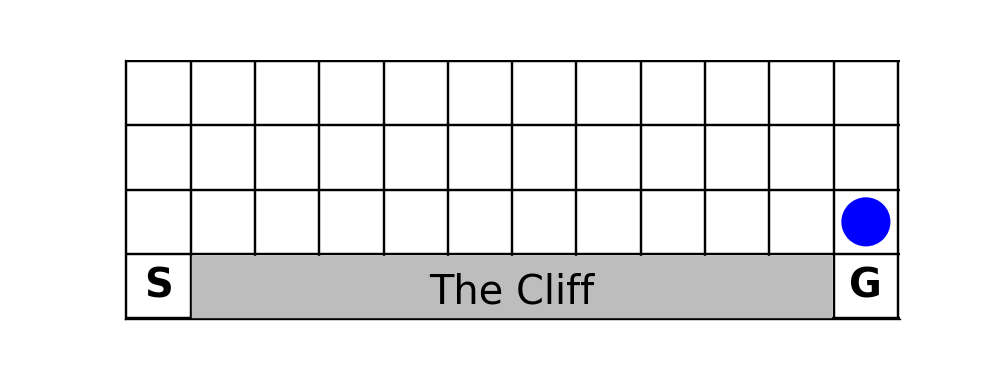

interactive(children=(IntSlider(value=23, description='state', max=47), Output()), _dom_classes=('widget-inter…

In [191]:
fig, ax = plt.subplots(figsize=(8,3))
show_grid_world(ax)
agent = ax.scatter([0],[0],s=800,c='b',zorder=60)

def move_states(state, agent):
    print ([state%12,state//12])
    agent.set_offsets([state%12,state//12])

widgets.interactive(move_states, state = (0,47,1), agent=widgets.fixed(agent))

## programming the environment

We need to define how the agent moves in the environment, following the possible actions

In [192]:
def take_action(state, action):
        
    if action == 0:  # move right
        next_state = state + 1
        if state % 12 == 11:  # right border
            next_state = state
            
    elif action == 1:  # move down
        next_state = state - 12
        if state <= 11:  # bottom border
            next_state = state
    
    elif action == 2:  # move left
        next_state = state - 1
        if state % 12 == 0:  # left border
            next_state = state
            
    elif action == 3:  # move up
        next_state = state + 12
        if state >= 36:  # top border
            next_state = state
    
    else:
        print("Action must be between 0 and 3.")
        return None

    return int(next_state)

We can now test whether the actions have the correct effect in the world

<IPython.core.display.Javascript object>


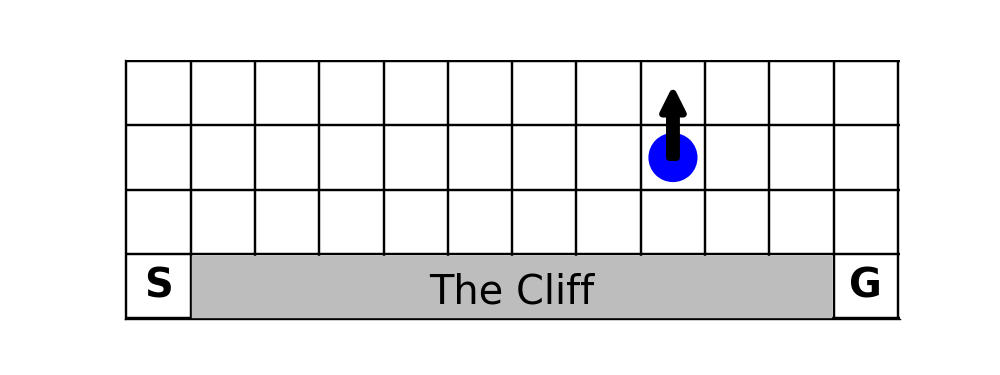

interactive(children=(IntSlider(value=49, description='state_index', max=99), Output()), _dom_classes=('widget…

In [193]:
def setup_visualization(state = 0):

    fig, ax = plt.subplots(figsize=(8,3))
    show_grid_world(ax)
    state_2d = [state%12,state//12] 
    agent = ax.scatter(state_2d[0],state_2d[1],s=800,c='b',zorder=60)
    arrow = ax.annotate("",
                  xy=(0, 1), xycoords='data',
                  xytext=(1, 1), textcoords='data',
                  arrowprops=dict(#arrowstyle="-",
                                  connectionstyle="arc3,rad=0.",
                                  linewidth=4, fc='k'),
                        zorder = 100,
                        annotation_clip = False
                  )
    
    return fig, ax, agent, arrow



state = 0
fig, ax, agent, arrow = setup_visualization(state )
n_steps = 100
all_actions = []
all_states = [state]

for ii in range(n_steps):
   
    action = np.random.choice(4)
    state = take_action(state, action)
    
    all_actions.append(action)
    all_states.append(state)
    
    
def visualize_taken_actions(state_index, agent, all_states, all_actions):
   
    state = all_states[state_index]
    action = all_actions[state_index]
    
    x = state%12
    y =state//12
  
    if action == 0:
        target_x, target_y = x + 1, y
    if action == 1:
        target_x, target_y = x, y - 1
    if action == 2:
        target_x, target_y = x - 1, y
    if action == 3:
        target_x, target_y = x, y + 1
    
    arrow.xy = (target_x ,target_y )

    arrow.set_position([x,y])
    agent.set_offsets([x,y])
    

widgets.interactive(visualize_taken_actions, state_index = (0,len(all_states)-2,1), 
                    agent=widgets.fixed(agent),
                    all_states=widgets.fixed(all_states),
                    all_actions=widgets.fixed(all_actions),
                    arrow = widgets.fixed(arrow),
                    
                   )


Next we need to define the rewards the agent recieves for reaching a certain state

In [194]:
def get_reward(state):
    
    if state >= 1 and state <= 10: # cliff
        return -100
    elif state == 11: # goal
        return 0
    else:
        return -1 

Now we can define an episode

<IPython.core.display.Javascript object>


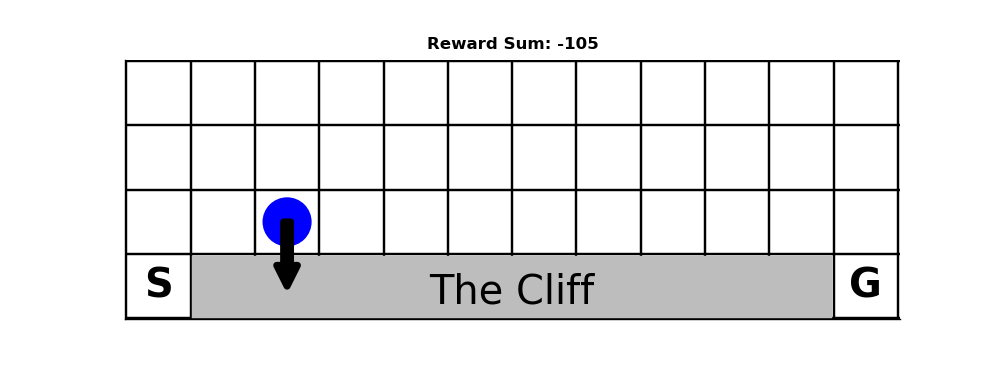

interactive(children=(IntSlider(value=2, description='state_index', max=5), Output()), _dom_classes=('widget-i…

In [195]:
def random_policy(**args):
    return np.random.choice(4)

def run_episode(policy, state=0):
        
    all_actions = []
    all_states = [state]
    
    max_steps = 2000
    reward_sum = 0
        
    for t in range(max_steps):
        # choose next action
        action = policy()
        all_actions.append(action)

        # observe outcome of action on environment
        next_state = take_action(state, action)
        reward = get_reward(next_state)

        # sum rewards obtained
        reward_sum += reward

        if reward == -100 or reward == 0:
            break  # episode ends
        state = next_state
        
        all_states.append(state)
     
    return all_states, all_actions, reward_sum
    

state = 0
fig, ax, agent, arrow = setup_visualization(state )    
all_states, all_actions, reward_sum = run_episode(policy=random_policy, state = state)
ax.set_title(f'Reward Sum: {reward_sum}')


    
widgets.interactive(visualize_taken_actions, state_index = (0,len(all_states)-1,1), 
                    agent=widgets.fixed(agent),
                    all_states=widgets.fixed(all_states),
                    all_actions=widgets.fixed(all_actions)
                    
                   )

We can see that the random approach is not very efficient. We need to learn a better policy!

In order to do so we put all the code we wrote so far into a single class:

To do so we need to learn a value function of the environment. In this case we are going to learn the state-action values. 

The function to learn is similar to running a single episode. Only now we run many episodes (another for-loop) and we want to update the state-action values. 
To see these values, we first write a function to display them in the grid world.

Every state has for values and we are interested in the best one. Therefore we will display the values as colored triangles and the best action of each state will be a circle:


In [363]:
def show_state_action_values_in_grid(ax = None, min_val = 0, max_val = 0, state_action_values=np.random.rand(48,4)):
        
        fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

#         self.state_action_values = -100*np.random.rand(self.n_states,4)
        
        ax = show_grid_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State-action value")
        
        # the four triangle paths for the four actions
        triangle_paths = np.array([
            [[0.55,0.5],[0.95,0.95],[0.95,0.05]],
            [[0.5,0.45],[0.9,0.05],[0.1,0.05]],
            [[0.45,0.5],[0.05,0.05],[0.05,0.9]],
            [[0.5,0.55],[0.05,0.95],[0.9,0.95]]           
        ])
        
        for state in range(state_action_values.shape[0]):
            
            for action in range(4):
                
                state_2d = np.array([state%12,state//12]).astype(float)
                
                path = triangle_paths[action]+state_2d - np.array([0.5,0.5])
                # convert the state-value to color 
                color = cmap(norm(state_action_values[state,action]))
                
                if np.argmax(state_action_values[state]) == action:
                    ax.scatter(*np.mean(path,axis=0),color=color, edgecolor='k')
                else:
                    triang=mpatches.Polygon(path,
                                    fill=True,
                                    color=color,zorder=10)
                    
                    ax.add_patch(triang)
                    

We look at an example (just random values)

<IPython.core.display.Javascript object>


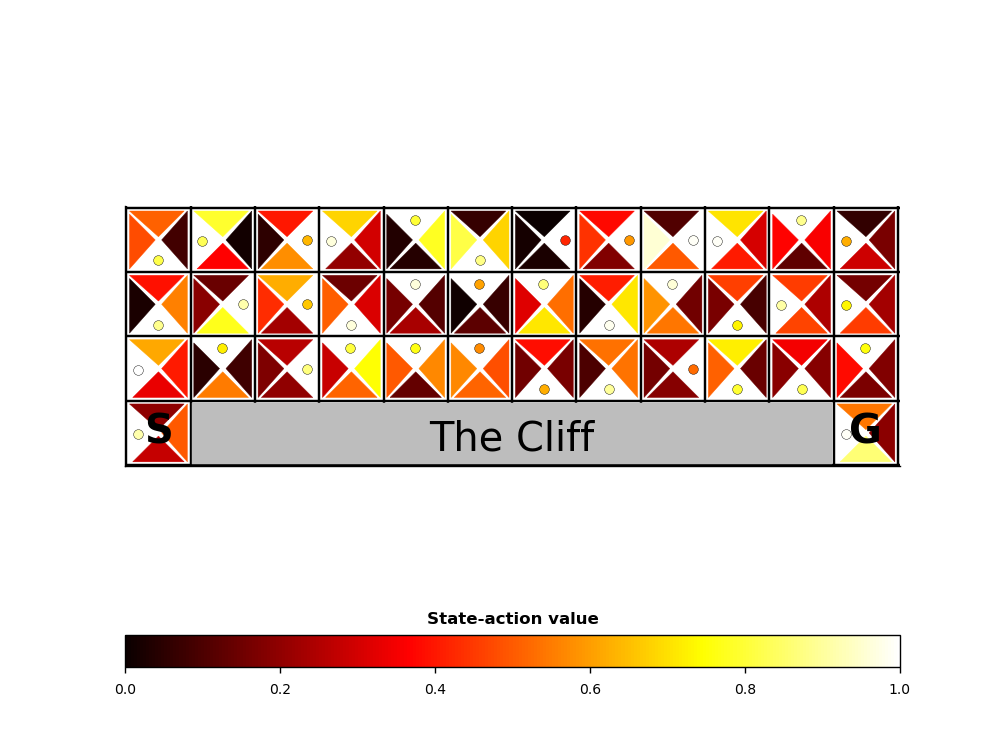

In [364]:
show_state_action_values_in_grid(ax = None, min_val = 0, max_val = 1, state_action_values=np.random.rand(48,4))

In order to learn, we need to have a policy that is better than random. 
A policy that is often used is $\epsilon$-greedy
We always take the best action, but in a fraction $\epsilon$ we select a random action. 
This ensures that the agent keeps exploring, but on average it tries to select the best possible action. 

In [365]:
def epsilon_greedy(q, epsilon):
    
    if np.random.random() > epsilon:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

        
    return action

We also need a learning rule in order to update the state-action values. We learned a couple of variants in the lecture, here we select q-learning.


In [374]:
def q_learning(state, action, reward, next_state, state_action_values, params):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        max_next_q = 0
    else:
        max_next_q = np.max(state_action_values[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error

    return state_action_values # we also return the state_values (although not changed) 

now we can implement this into the function that learns to move in the environment

In [380]:
def learn_environment(n_episodes, params, max_steps=400):
               
    # initiate the state-action values
    state_action_values = np.ones((48,4))

    # Loop over episodes
    for episode in range(n_episodes):
        state = 0  # initialize state, we start at state 0


        for t in range(max_steps):
            # choose next action
            action = epsilon_greedy(q = state_action_values[state], 
                             epsilon = params['epsilon'])
            # observe outcome of action on environment
            next_state = take_action(state, action)
            reward = get_reward(next_state)


            # update value function
            state_action_values = q_learning(
                state, 
                action, 
                reward, 
                next_state, 
                state_action_values, 
                params
            )

            if reward in [-100, 0]:
                break  # episode ends
            state = next_state
    return state_action_values

<IPython.core.display.Javascript object>


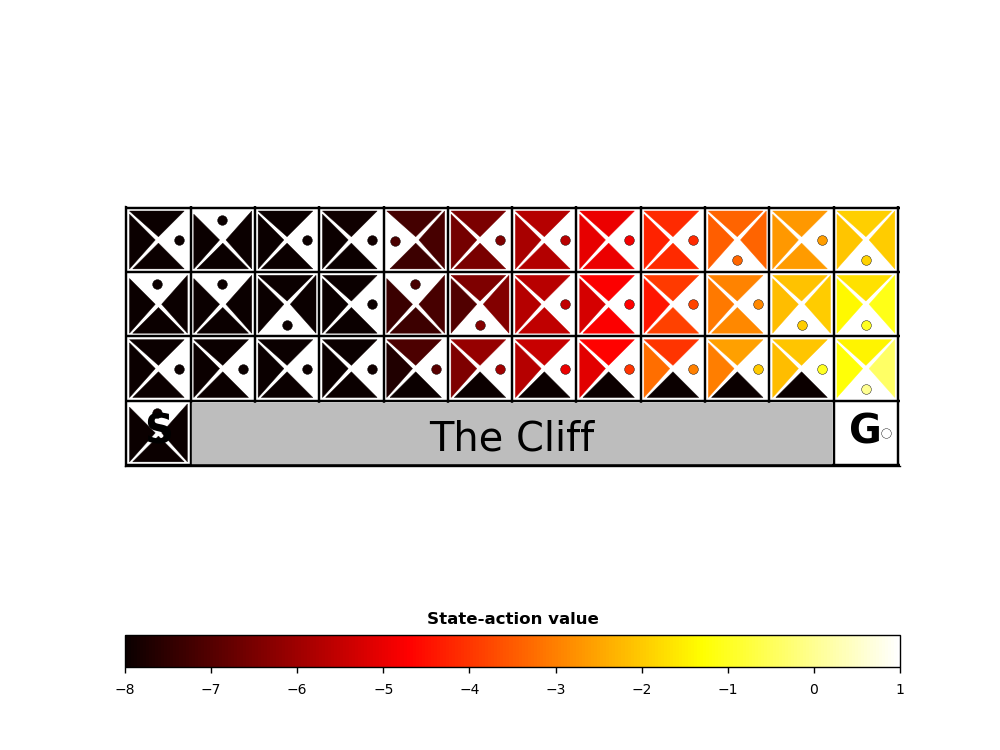

In [381]:
params = {
  'epsilon': 0.2,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}
state_action_values = learn_environment(n_episodes=400, params=params, max_steps=400)
show_state_action_values_in_grid(ax = None, min_val = -8, max_val = 1, state_action_values=state_action_values)

In [382]:
class CliffWorld(object):
    def __init__(self, grid_length = 12, grid_height = 4):
        self.init_state = 0
        self.max_steps = 2000
        
        self.grid_length = grid_length
        self.grid_height = grid_height
        
        self.n_states = self.grid_length * self.grid_height 
        self.n_actions = 4
        
        
        # initialize state and state-action values
        self.state_values = np.zeros(self.n_states)
        self.state_action_values = np.zeros((self.n_states,self.n_actions))
    
    
    def run_episode(self, policy):
        
        
        state = self.init_state
        all_actions = []
        all_states = [state]

        
        reward_sum = 0

        for t in range(self.max_steps):
            # choose next action
            action = policy()
            all_actions.append(action)

            # observe outcome of action on environment
            next_state = take_action(state, action)
            reward = get_reward(next_state)

            # sum rewards obtained
            reward_sum += reward

            if reward == -100 or reward == 0:
                break  # episode ends
            state = next_state

            all_states.append(state)
        
        self.all_states, self.all_actions, self.reward_sum = all_states, all_actions, reward_sum
                    
        return all_states, all_actions, reward_sum
                    
    
    def show_last_run_interactive(self):
           
        
        fig, ax, agent, arrow = self.setup_visualization()    
        ax.set_title(f'Reward Sum: {self.reward_sum}')
        
        
        wgt = widgets.interactive(self.visualize_taken_actions, state_index = (0,len(self.all_states)-1,1), 
                agent=widgets.fixed(agent),
                arrow=widgets.fixed(arrow),

               )
        
        return wgt

    
    def show_state_values_in_grid(self, ax = None, min_val = 0, max_val = 0):
        
        fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

        self.state_values = -100*np.random.rand(self.n_states)
        
        ax = self.show_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State value")
        for state in range(self.n_states):
            state_2d = np.array([state%self.grid_length,state//self.grid_length]).astype(float)
            state_2d -= np.array([0.47,0.47])
            
            # convert the state-value to color 
            color = cmap(norm(self.state_values[state]))
            rect=mpatches.Rectangle(state_2d,width=0.94,height=0.94, 
                                fill=True,
                                color=color,zorder=10)
            ax.add_patch(rect)
            
    def show_state_action_values_in_grid(self, ax = None, min_val = 0, max_val = 0):
        
        fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

#         self.state_action_values = -100*np.random.rand(self.n_states,4)
        
        ax = self.show_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State-action value")
        
        # the four triangle paths for the four actions
        triangle_paths = np.array([
            [[0.55,0.5],[0.95,0.95],[0.95,0.05]],
            [[0.5,0.45],[0.9,0.05],[0.1,0.05]],
            [[0.45,0.5],[0.05,0.05],[0.05,0.9]],
            [[0.5,0.55],[0.05,0.95],[0.9,0.95]]           
        ])
        
        for state in range(self.n_states):
            
            for action in range(4):
                
                state_2d = np.array([state%self.grid_length,state//self.grid_length]).astype(float)
                
                path = triangle_paths[action]+state_2d - np.array([0.5,0.5])
                # convert the state-value to color 
                color = cmap(norm(self.state_action_values[state,action]))
                
                if np.argmax(self.state_action_values[state]) == action:
                    ax.scatter(*np.mean(path,axis=0),color=color, edgecolor='k')
                else:
                    triang=mpatches.Polygon(path,
                                    fill=True,
                                    color=color,zorder=10)
                    
                    ax.add_patch(triang)
                
    
    
    
    def take_action(self, state, action):
        
        if action == 0:  # move right
            next_state = state + 1
            if state % self.grid_length == self.grid_length-1:  # right border
                next_state = state

        elif action == 1:  # move down
            next_state = state - self.grid_length
            if state <= self.grid_length-1:  # bottom border
                next_state = state

        elif action == 2:  # move left
            next_state = state - 1
            if state % self.grid_length == 0:  # left border
                next_state = state

        elif action == 3:  # move up
            next_state = state + self.grid_length
            if state >= self.grid_length * self.grid_height:  # top border
                next_state = state

        else:
            print("Action must be between 0 and 3.")
            return None

        return int(next_state)
    
    
    def get_reward(self, state):
    
        if state >= 1 and state < self.grid_length-1: # cliff
            return -100
        elif state == 11: # goal
            return 0
        else:
            return -1 
        
    def show_world(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots(figsize=(8,6))



        ax.grid(linewidth = 1.4, c='k')
        ax.set(
            xticks = [0.5+ii for ii in range(-1,12)],
            yticks = [0.5 + ii for ii in range(-1,4)],
            xlim=[-0.52,11.53],
            ylim = [-0.51,3.52])


        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

        ax.set_aspect('equal', adjustable='box')
        rect=mpatches.Rectangle((0.52,-0.49),9.96,0.96, 
                                fill=True,
                                color="#bdbdbd",zorder=50)
        ax.add_patch(rect)

        ax.annotate('S',(0,0), fontweight='bold',fontsize=23,ha='center',va='center', zorder=12)
        ax.annotate('G',(11,0), fontweight='bold',fontsize=23,ha='center',va='center', zorder=12)
        ax.annotate('The Cliff',(5.5,-0.1), fontsize=23,ha='center',va='center',zorder=200)
        return ax
        
    def visualize_taken_actions(self, state_index, agent, arrow):
   
        state = self.all_states[state_index]
        action = self.all_actions[state_index]

        x = state%12
        y =state//12

        if action == 0:
            target_x, target_y = x + 1, y
        if action == 1:
            target_x, target_y = x, y - 1
        if action == 2:
            target_x, target_y = x - 1, y
        if action == 3:
            target_x, target_y = x, y + 1

        arrow.xy = (target_x ,target_y )

        arrow.set_position([x,y])
        agent.set_offsets([x,y])
                    
    def setup_visualization(self, state = 0):

        fig, ax = plt.subplots(figsize=(8,3))
        self.show_world(ax)
        state_2d = [self.init_state%12,self.init_state//12] 
        agent = ax.scatter(state_2d[0],state_2d[1],s=800,c='b',zorder=60)
        arrow = ax.annotate("",
                      xy=(0, 1), xycoords='data',
                      xytext=(1, 1), textcoords='data',
                      arrowprops=dict(#arrowstyle="-",
                                      connectionstyle="arc3,rad=0.",
                                      linewidth=4, fc='k'),
                            zorder = 100,
                            annotation_clip = False
                      )

        return fig, ax, agent, arrow
    
    def initiate_values(self, initiation_keyword):
        
        if initiation_keyword == 'ones':
            
            self.state_values = np.ones(self.n_states)
            self.state_action_values = np.ones((self.n_states,self.n_actions))
    
    def learn_environment(self,  learning_rule, policy, params, n_episodes,
                          initiation_keyword='ones',):
               
        self.initiate_values(initiation_keyword)

        # Run learning
        reward_sums = np.zeros(n_episodes)
    
    
        



        # Loop over episodes
        for episode in range(n_episodes):
            state = self.init_state  # initialize state
            reward_sum = 0
            
            next_action = policy(v = self.state_values[state], 
                                 q = self.state_action_values[state], 
                                 params = params)

            for t in range(self.max_steps):
                # choose next action
                action = next_action
                # observe outcome of action on environment
                next_state = take_action(state, action)
                reward = get_reward(next_state)
                
                next_action = policy(v = self.state_values[next_state], 
                                     q = self.state_action_values[next_state], 
                                     params = params)
                
                # update value function
                self.state_values, self.state_action_values = learning_rule(
                    state, 
                    action, 
                    reward, 
                    next_state, 
                    next_action, 
                    self.state_values,
                    self.state_action_values, 
                    params
                )

                # sum rewards obtained
                reward_sum += reward

                if reward in [-100, 0]:
                    break  # episode ends
                state = next_state

            reward_sums[episode] = reward_sum

        return reward_sums
    

In [383]:
def policy_epsilon_greedy(**kwargs):
    
    q = kwargs['q']
    
    if np.random.random() > kwargs['params']['epsilon']:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

        
    return action

In [384]:
def sarsa_learning(state, action, reward, next_state, next_action, state_values, state_action_values, params):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        next_q = 0
    else:
        next_q = state_action_values[next_state, next_action]

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error
    
    return state_values, state_action_values # we also return the state_values (although not changed) 

def q_learning(state, action, reward, next_state, next_action, state_values, state_action_values, params):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        max_next_q = 0
    else:
        max_next_q = np.max(state_action_values[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error

    return state_values, state_action_values # we also return the state_values (although not changed) 


<IPython.core.display.Javascript object>


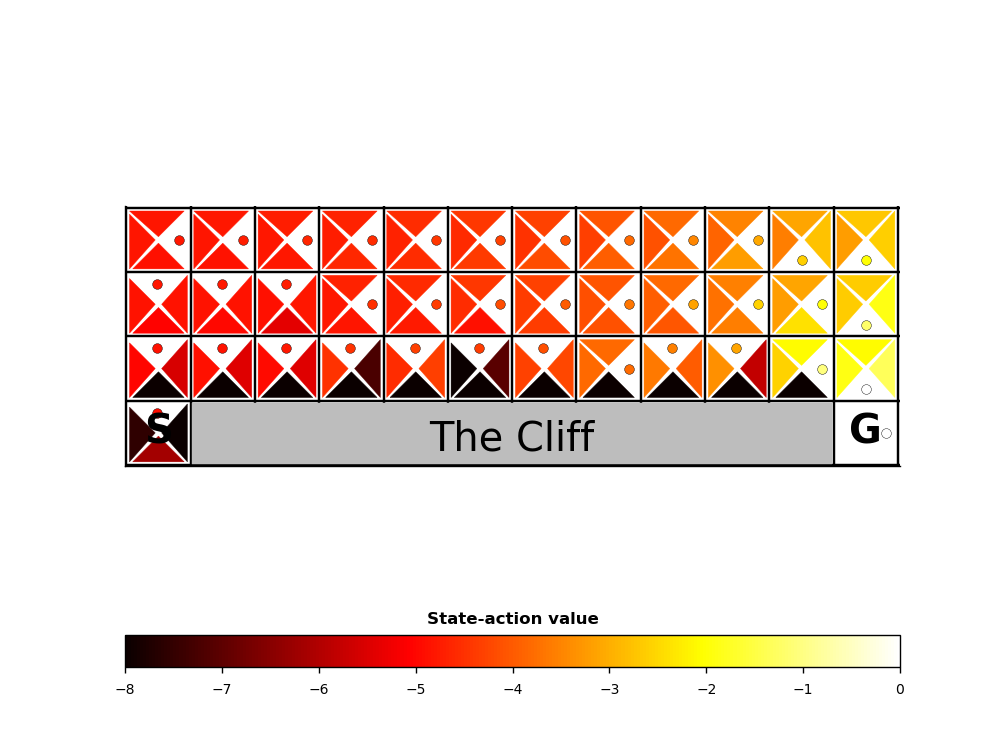

In [350]:
sample_cliff = CliffWorld()
# sample_cliff.run_episode(policy=policy_epsilon_greedy)

params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 0.8,  # discount factor
}

np.random.seed(12)
sample_cliff.learn_environment(
    learning_rule = sarsa_learning, 
    policy=policy_epsilon_greedy,
    params = params, 
    n_episodes = 10_000,
    initiation_keyword='ones',)
sample_cliff.show_state_action_values_in_grid(ax = None, min_val=-8, max_val = 0)

<AxesSubplot:>

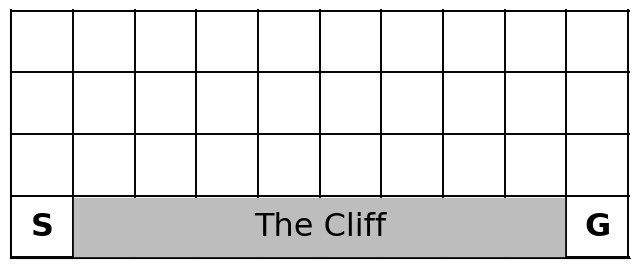

In [3]:
def plot_state_action_values(env, value, ax=None):
    """
    Generate plot showing value of each action at each state.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for a in range(env.n_actions):
        ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
    ax.set(xlabel='States', ylabel='Values')
    ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
    """
        Generate plot showing action of maximum value or maximum probability at
        each state (not for n-armed bandit or cheese_world).
    """
    if ax is None:
        fig, ax = plt.subplots()

    X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
    Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
    which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
    which_max = which_max[::-1,:]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    U[which_max == 0] = 1
    V[which_max == 1] = 1
    U[which_max == 2] = -1
    V[which_max == 3] = -1

    ax.quiver(X, Y, U, V)
    ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
    )
    ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
    ax.set_xticks(np.arange(env.dim_x+1), minor=True)
    ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
    ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
    ax.set_yticks(np.arange(env.dim_y+1), minor=True)
    ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
    """
    Generate heatmap showing maximum value at each state
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    if value.ndim == 1:
        value_max = np.reshape(value, (env.dim_y,env.dim_x))
    else:
        value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
    value_max = value_max[::-1,:]

    im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
    ax.set(title='Maximum value per state')
    ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
    ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
    if env.name != 'windy_cliff_grid':
        ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
    return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
    """
    Generate plot showing total reward accumulated in each episode.
    """
    if ax is None:
        fig, ax = plt.subplots()

    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

    ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
    ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    plot_state_action_values(env, value, ax=axes[0,0])
    plot_quiver_max_action(env, value, ax=axes[0,1])
    plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
    im = plot_heatmap_max_val(env, value, ax=axes[1,1])
    fig.colorbar(im)

In [4]:


def q_learning(state, action, reward, next_state, next_action, value, params):
    """Q-learning: updates the value function and returns it.
    Args:
        state (int): the current state identifier
        action (int): the action taken
        reward (float): the reward received
        next_state (int): the transitioned to state identifier
        value (ndarray): current value function of shape (n_states, n_actions)
        params (dict): a dictionary containing the default parameters
    Returns:
        ndarray: the updated value function of shape (n_states, n_actions)
    """
    # Q-value of current state-action pair
    q = value[state, action]

    # write an expression for finding the maximum Q-value at the current state
    if next_state is None:
        max_next_q = 0
    else:
        max_next_q = np.max(value[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    value[state, action] = q + params['alpha'] * td_error

    return value

def sarsa_learning(state, action, reward, next_state, next_action, value, params):
    """Q-learning: updates the value function and returns it.
    Args:
        state (int): the current state identifier
        action (int): the action taken
        reward (float): the reward received
        next_state (int): the transitioned to state identifier
        value (ndarray): current value function of shape (n_states, n_actions)
        params (dict): a dictionary containing the default parameters
    Returns:
        ndarray: the updated value function of shape (n_states, n_actions)
    """
    # Q-value of current state-action pair
    q = value[state, action]
    if next_state is None:
        next_q = 0
    else:
        next_q = value[next_state, next_action]

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * next_q - q
    # write the expression that updates the Q-value for the state-action pair
    value[state, action] = q + params['alpha'] * td_error

    return value


# # set for reproducibility, comment out / change seed value for different results
# np.random.seed(1)

# # parameters needed by our policy and learning rule
# params = {
#   'epsilon': 0.1,  # epsilon-greedy policy
#   'alpha': 0.1,  # learning rate
#   'gamma': 1.0,  # discount factor
# }

# # episodes/trials
# n_episodes = 500
# max_steps = 1000

# # environment initialization
# env = CliffWorld()

# # solve Cliff World using Q-learning
# results = learn_environment(env, q_learning, params, max_steps, n_episodes)
# value_qlearning, reward_sums_qlearning = results

# # Plot results
# plot_performance(env, value_qlearning, reward_sums_qlearning)

interactive(children=(IntSlider(value=19, description='state', max=39), Output()), _dom_classes=('widget-inter…

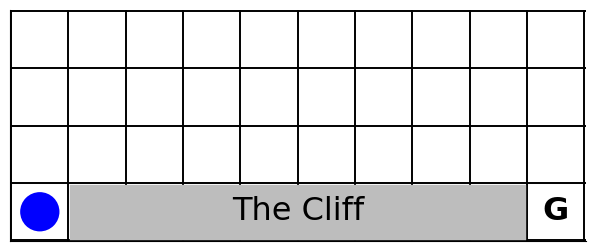

0.2
0.2


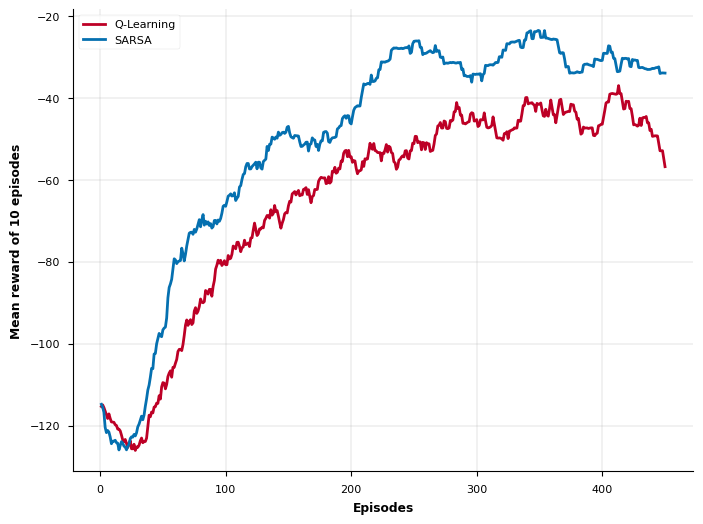

In [12]:



def learn_environment(env, learning_rule, params, max_steps, n_episodes):
    # Start with a uniform value function
    value = np.ones((env.n_states, env.n_actions))

    # Run learning
    reward_sums = np.zeros(n_episodes)
    
    all_states = []
    all_actions = []
    
    initial_epsilon =  params['epsilon']
    
    # Loop over episodes
    for episode in range(n_episodes):
        state = env.init_state  # initialize state
        reward_sum = 0
        
        all_states.append([state])
        all_actions.append([])
        
        next_action = epsilon_greedy(value[state], params['epsilon'])
        
#         params['epsilon'] = initial_epsilon * (n_episodes-1 - episode)/n_episodes

        for t in range(max_steps):
            # choose next action
            
            action = next_action
            all_actions[-1].append(action)
            # observe outcome of action on environment
            next_state, reward = env.get_outcome(state, action)
            all_states[-1].append(next_state)
            
            next_action = epsilon_greedy(value[next_state], params['epsilon'])
            

            # update value function
            value = learning_rule(state, action, reward, next_state, next_action, value, params)

            # sum rewards obtained
            reward_sum += reward

            if next_state is None:
                break  # episode ends
            state = next_state

        reward_sums[episode] = reward_sum
        
    print (params['epsilon'])
    return all_states, all_actions, reward_sums

params = {
  'epsilon': 0.2,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results_q_learning = learn_environment(env, q_learning, params, max_steps, n_episodes)
results_sarsa_learning = learn_environment(env, sarsa_learning, params, max_steps, n_episodes)
# value_qlearning, reward_sums_qlearning = results
all_states_q_learning, all_actions_q_learning, reward_sums_q_learning = results_q_learning
all_states_sarsa_learning, all_actions_sarsa_learning, reward_sums_sarsa_learning = results_sarsa_learning

fig, ax = plt.subplots()

kernel_size = 50
kernel = np.ones(kernel_size) / kernel_size

X = np.linspace(1-kernel_size,n_episodes,n_episodes+kernel_size)
ax.plot(X[kernel_size:-kernel_size],np.convolve(np.hstack([-100*np.ones(kernel_size),reward_sums_q_learning]), kernel,
                                               mode='same')[kernel_size:-kernel_size], c='#bd0026', label='Q-Learning')
ax.plot(X[kernel_size:-kernel_size],np.convolve(np.hstack([-100*np.ones(kernel_size),reward_sums_sarsa_learning]), kernel,
                                               mode='same')[kernel_size:-kernel_size], c='#0570b0', label = 'SARSA')
ax.set(
    xlabel = 'Episodes',
    ylabel = 'Mean reward of 10 episodes')
ax.legend()

interactive(children=(IntSlider(value=0, description='episode', max=499), IntSlider(value=0, description='move…

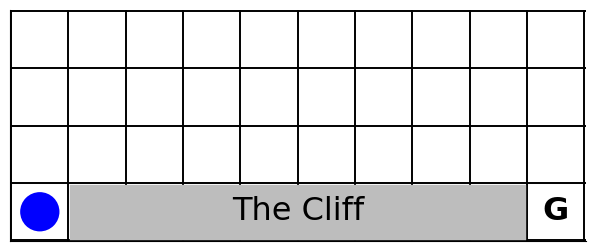

In [8]:
fig, ax = plt.subplots(figsize=(8,3))
show_grid_world(ax)
agent = ax.scatter([0],[0],s=800,c='b',zorder=60)
positions = ax.plot([0],[0])[0]
def visualise_agent_movements(episode=0, move_number=0, learning='q-learning'):
    
    if learning == 'sarsa':
        all_states = all_states_sarsa_learning
        all_actions = all_actions_sarsa_learning
    if learning == 'q-learning':
        all_states = all_states_q_learning
        all_actions = all_actions_q_learning
        
    
    states_of_episode = all_states[episode]
    actions_of_episode = all_actions[episode] + [0]
    
    move_index = min([move_number,len(states_of_episode)-1])
    
    state = states_of_episode[move_index]
    if state == None:
        agent.set_offsets([4.5,0])
    else:
        agent.set_offsets([state%10,state//10])
    x = [state%10 - 0.3 + 0.6*ii/(len(states_of_episode)) for ii, state in enumerate(states_of_episode) if state != None]
    y = [state//10 - 0.3 + 0.6*ii/(len(states_of_episode)) for ii, state in enumerate(states_of_episode) if state != None]
    positions.set_xdata(x)
    positions.set_ydata(y)

    
widgets.interactive(visualise_agent_movements, episode=(0,n_episodes-1,1),move_number=(0,200,1), learning = ['sarsa','q-learning'])

In [9]:
class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        # Time step at which the conditioned stimulus is presented
        self.set_reward(reward_magnitude, reward_time)

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]

In [10]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
    V = np.zeros(env.n_steps) # Array to store values over states (time)
    TDE = np.zeros((env.n_steps, n_trials+1)) # Array to store TD errors
    V_store = np.zeros((env.n_steps, n_trials+1))

    for n in range(1,n_trials+1):
        state = 0 # Initial state
        for t in range(env.n_steps):

            # Get next state and next reward
            next_state, reward = env.get_outcome(state)

            # Is the current state in the delay period (after CS)?
            is_delay = env.state_dict[state][0]

            # Write an expression to compute the TD-error
            if n > 19800:
                reward = 0
            TDE[state, n] = (reward + gamma * V[next_state] - V[state])

            # Write an expression to update the value function
            V[state] += alpha * TDE[state, n] * is_delay

            # Update state
            state = next_state
        V_store[:,n] = V[:]

    return V_store, TDE

n_steps=40
# Initialize classical conditioning class
env = ClassicalConditioning(n_steps=n_steps, reward_magnitude=10, reward_time=10)

n_trials = 20000
# Perform temporal difference learning
V, TDE = td_learner(env, n_trials=n_trials)




# indx = np.arange(0, TDE.shape[1], skip)
# im = ax2.imshow(TDE[:,indx])
# positions = ax2.get_xticks()
# # Avoid warning when setting string tick labels
# # ax2.xaxis.set_major_locator(ticker.FixedLocator(positions))
# ax2.set_xticklabels([f"{int(skip * x)}" for x in positions])
# ax2.set_title('TD-error over learning')
# ax2.set_ylabel('State')
# ax2.set_xlabel('Iterations')
# ax2.figure.colorbar(im)
# fig.tight_layout()


  

In [11]:
def show_results(trial=0):


    fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(8,4), gridspec_kw={'height_ratios': [1, 1]}, sharex = True)
    markerline, stemlines, baseline = ax1.stem(V[:,trial], use_line_collection=True, linefmt='grey', markerfmt='o')
    baseline.set_color((0,0,0,0))
    ax1.set(
        ylabel = 'Value',
        xlabel = 'State',
        title = "Value function: $V(s)$",
        ylim = [-0.5,10.5])

    ax2.scatter(np.linspace(1,n_steps-1,n_steps-1), TDE[:-1,trial], color='#cb181d')
    ax2.axvline(x=19.5, color='#54278f')
    ax2.axvline(x=9.5, color='#fe9929', linewidth=2)
    ax2.set(
        ylabel = 'Value',
        xlabel = 'State',
        title = "Temporal difference error",
        ylim = [-10.5,10.5])
    
    fig.tight_layout()
    
widgets.interactive(show_results, trial=(1,n_trials,100))

interactive(children=(IntSlider(value=1, description='trial', max=20000, min=1, step=100), Output()), _dom_cla…